In [ ]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
import warnings
from tqdm import tqdm_notebook

warnings.filterwarnings(action='ignore')

In [ ]:
DATA_DIR = '/content/drive/MyDrive/투빅스 컨퍼런스/Data/'

game_meta_df = pd.read_csv(DATA_DIR + 'steam_image_meta_data_clean_result.csv')
game_meta_df = game_meta_df.drop_duplicates().reset_index(drop=True)
game_meta_df = game_meta_df.sort_values('game_id').reset_index(drop = True)

user_review_df = pd.read_csv(DATA_DIR + 'steam_reviews_clean_result.csv')

In [ ]:
game_meta_df.head()

,game_id,title,content,Image_url,genres,clean_genres,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags,label_encode_game_id
0,10,Counter-Strike,Play the world's number 1 online action game. ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",10,Counter-Strike,Valve,Valve,NaN,178066,4597,0,"10,000,000 .. 20,000,000",12516,431,185,764,199.0,999.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,13111,"{'Action': 5355, 'FPS': 4771, 'Multiplayer': 3...",0
1,20,Team Fortress Classic,One of the most popular online action games of...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"['Action', 'FPS', 'Multiplayer', 'Classic', 'H...",20,Team Fortress Classic,Valve,Valve,NaN,4949,838,0,"2,000,000 .. 5,000,000",2353,0,17,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,89,"{'Action': 741, 'FPS': 302, 'Multiplayer': 255...",1
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tFPS\t\t\t\t\t\t\...,"['FPS', 'World War II', 'Multiplayer', 'Shoote...",30,Day of Defeat,Valve,Valve,NaN,4723,521,0,"5,000,000 .. 10,000,000",2164,0,39,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 780, 'World War II': 245, 'Multiplayer...",2
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"['Action', 'FPS', 'Classic', 'Multiplayer', 'S...",40,Deathmatch Classic,Valve,Valve,NaN,1733,377,0,"5,000,000 .. 10,000,000",2862,0,11,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,5,"{'Action': 627, 'FPS': 137, 'Classic': 105, 'M...",3
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tFPS\t\t\t\t\t\t\...,"['FPS', 'Action', 'Classic', 'Sci-fi', 'Single...",50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,11285,581,0,"5,000,000 .. 10,000,000",1494,0,208,0,99.0,499.0,80.0,"English, French, German, Korean",Action,137,"{'FPS': 874, 'Action': 316, 'Sci-fi': 242, 'Cl...",4


In [ ]:
user_review_df.head()

,content,recommended,user_id,game_id,timestamp,play_time_minute,review_time_minute,game_content_link,review_helpful_count,label_encode_user_id,label_encode_game_id
0,"Very good game, within 6 hours from launch, th...",Recommended,atgbui,768520,2021-06-20,3042.0,3042.0,https://store.steampowered.com/app/768520,5,19302,15392
1,I cannot recommend this game. It's been 8 year...,Not Recommended,atgbui,251570,2021-06-14,40440.0,40440.0,https://store.steampowered.com/app/251570,48,19302,2415
2,Game is currently busted for Co-Op. Despite th...,Not Recommended,atgbui,671510,2021-06-12,1734.0,906.0,https://store.steampowered.com/app/671510,3,19302,13585
3,Unfortunately dead game. https://steamcharts.c...,Not Recommended,atgbui,613590,2021-06-12,48.0,48.0,https://store.steampowered.com/app/613590,0,19302,12513
4,It just felt too generic- why would I play thi...,Not Recommended,atgbui,374280,2021-05-20,540.0,540.0,https://store.steampowered.com/app/374280,1,19302,6269


In [ ]:
user_review_df.drop_duplicates('user_id')

,content,recommended,user_id,game_id,timestamp,play_time_minute,review_time_minute,game_content_link,review_helpful_count,label_encode_user_id,label_encode_game_id
0,"Very good game, within 6 hours from launch, th...",Recommended,atgbui,768520,2021-06-20,3042.0,3042.0,https://store.steampowered.com/app/768520,5,19302,15392
50,Best game.,Recommended,76561198120102283,1325200,2021-03-10,3432.0,3432.0,https://store.steampowered.com/app/1325200,0,8135,21600
69,Disrespectful Developers & Wasted of Time DC U...,Not Recommended,113L1T3G0DM4N3X1T11,24200,2021-06-19,4236.0,4236.0,https://store.steampowered.com/app/24200,0,82,538
79,"Unexpected find, surprisingly fun, I want to m...",Recommended,_treeheart_,712190,2020-06-01,948.0,948.0,https://store.steampowered.com/app/712190,0,18671,14357
89,After over 5500 hours in Path Of Exile this is...,Recommended,Jamzuz,899770,2021-05-25,2508.0,414.0,https://store.steampowered.com/app/899770,1,14352,17493
...,...,...,...,...,...,...,...,...,...,...,...
1078155,Definitely worth the time and the money. Deep ...,Recommended,76561198011750071,337000,2016-11-27,1698.0,1578.0,https://store.steampowered.com/app/337000,2,3423,4877
1078167,madarchod game hai chutiyapa game hai randi ch...,Not Recommended,76561198253938362,359550,2020-12-02,7758.0,7320.0,https://store.steampowered.com/app/359550,3,9846,5750
1078175,This game is good when you get legit games but...,Not Recommended,76561198101206727,730,2021-06-08,43158.0,43158.0,https://store.steampowered.com/app/730,1,7473,26
1078187,Muito bom,Recommended,76561198104647369,50130,2020-01-31,1050.0,990.0,https://store.steampowered.com/app/50130,0,7554,934


In [ ]:
user_review_df['user_id']

0                     atgbui
1                     atgbui
2                     atgbui
3                     atgbui
4                     atgbui
                 ...        
1078214    76561198124865235
1078215    76561198124865235
1078216    76561198124865235
1078217    76561198124865235
1078218    76561198124865235
Name: user_id, Length: 1078219, dtype: object

- 유저가 한 게임의 수를 카운트한 게임 카운트 순위 피쳐
- 해당 유저가 한 게임의 장르를 다 더해서 해당 유저가 무슨 장르를 좋아하는 지 판단하는 피쳐
- 유저가 플레이한 게임 시간을 가지고 헤당 게임의 평균 플레이 시간을 나타내는 피쳐
- 유저가 좋아하는 게임과 좋아하지 않는 게임의 평균 플레이 시간을 나타내는 피쳐
- 해당 게임에 대한 유저의 추천/비추천 비율을 나타내는 피쳐

# user

- `played_game_cnt`:유저가 한 게임의 수를 카운트한 게임 카운트 순위 피쳐

- `avg_played_time`,`avg_Recom_played_time`,`avg_not_Recom_played_time`:유저가 좋아하는 게임과 좋아하지 않는 게임의 평균 플레이 시간을 나타내는 피쳐


In [ ]:
user = pd.DataFrame(index = user_review_df["user_id"].unique())

user['user_id'] = user.index

user['played_game_total_cnt'] = user_review_df.groupby('user_id').count()['game_id']
user["played_game_rec_cnt"] = user_review_df[user_review_df["recommended"] == "Recommended"].groupby(user_review_df['user_id']).count()['game_id']
user["played_game_not_rec_cnt"] = user_review_df[user_review_df["recommended"] != "Recommended"].groupby(user_review_df['user_id']).count()['game_id']

user["played_game_avg_play_time"] = user_review_df.groupby(user_review_df["user_id"])['play_time_minute'].mean()
user["played_game_rec_avg_play_time"] = user_review_df[user_review_df["recommended"]=="Recommended"].groupby(user_review_df['user_id'])["play_time_minute"].mean()
user["played_game_not_rec_avg_play_time"] = user_review_df[user_review_df["recommended"]!="Recommended"].groupby(user_review_df['user_id'])["play_time_minute"].mean()

user = user.fillna(0)

user.head()

,user_id,played_game_total_cnt,played_game_rec_cnt,played_game_not_rec_cnt,played_game_avg_play_time,played_game_rec_avg_play_time,played_game_not_rec_avg_play_time
atgbui,atgbui,50,25,25.0,8192.880000,13536.720000,2849.040000
76561198120102283,76561198120102283,19,6,13.0,8528.842105,9270.000000,8186.769231
113L1T3G0DM4N3X1T11,113L1T3G0DM4N3X1T11,10,7,3.0,8719.800000,6888.857143,12992.000000
_treeheart_,_treeheart_,10,6,4.0,9352.200000,15315.000000,408.000000
Jamzuz,Jamzuz,8,5,3.0,42954.750000,68553.600000,290.000000


In [ ]:
user.isna().sum()

user_id                              0
played_game_total_cnt                0
played_game_rec_cnt                  0
played_game_not_rec_cnt              0
played_game_avg_play_time            0
played_game_rec_avg_play_time        0
played_game_not_rec_avg_play_time    0
dtype: int64

# game
- `avg_play_time`,	`avg_Recom_played_time`,	`avg_not_Recom_played_time`:유저가 플레이한 게임 시간을 가지고 헤당 게임의 평균 플레이 시간을 나타내는 피쳐
- `recommend_ratio`,`not_recommend_ratio` : 해당 게임에 대한 유저의 추천/비추천 비율을 나타내는 피쳐

In [ ]:
game = pd.DataFrame(index = user_review_df["game_id"].unique())

game['game_id'] = game.index

game['game_total_cnt'] = user_review_df.groupby('game_id').count()['user_id']
game["game_rec_cnt"] = user_review_df[user_review_df["recommended"] == "Recommended"].groupby(user_review_df['game_id']).count()['user_id']
game["game_not_rec_cnt"] = user_review_df[user_review_df["recommended"] != "Recommended"].groupby(user_review_df['game_id']).count()['user_id']

game['recommend_ratio'] = game["game_rec_cnt"] / game['game_total_cnt']
game['not_recommend_ratio'] = game["game_not_rec_cnt"] / game['game_total_cnt']

game["game_total_avg_play_time"] = user_review_df.groupby(user_review_df["game_id"])['play_time_minute'].mean()
game["game_rec_avg_play_time"] = user_review_df[user_review_df["recommended"]=="Recommended"].groupby(user_review_df['game_id'])["play_time_minute"].mean()
game["game_not_rec_avg_play_time"] = user_review_df[user_review_df["recommended"]!="Recommended"].groupby(user_review_df['game_id'])["play_time_minute"].mean()

game = game.fillna(0)

game.head()

,game_id,game_total_cnt,game_rec_cnt,game_not_rec_cnt,recommend_ratio,not_recommend_ratio,game_total_avg_play_time,game_rec_avg_play_time,game_not_rec_avg_play_time
768520,768520,30,25.0,5.0,0.833333,0.166667,1226.200000,1376.400000,475.200000
251570,251570,1244,902.0,342.0,0.725080,0.274920,22576.403537,25499.694013,14866.438596
671510,671510,135,87.0,48.0,0.644444,0.355556,1159.244444,1502.758621,536.625000
613590,613590,12,8.0,4.0,0.666667,0.333333,319.500000,453.000000,52.500000
374280,374280,54,29.0,25.0,0.537037,0.462963,872.555556,1203.724138,488.400000


In [ ]:
game.isna().sum()

game_id                       0
game_total_cnt                0
game_rec_cnt                  0
game_not_rec_cnt              0
recommend_ratio               0
not_recommend_ratio           0
game_total_avg_play_time      0
game_rec_avg_play_time        0
game_not_rec_avg_play_time    0
dtype: int64

# user 선호 장르 파악 (rec 리뷰 기준으로)

In [ ]:
# 유저 선호 장르 파악을 위한 기본 데이터셋 만들기
game_meta_df['clean_genres'] = game_meta_df['clean_genres'].apply(lambda x: eval(x))

te = TransactionEncoder()
te_ary = te.fit(game_meta_df['clean_genres'].values).transform(game_meta_df['clean_genres'].values)

game_genres_df = pd.DataFrame(te_ary, columns=te.columns_)
game_genres_df.iloc[:, :] = game_genres_df.values.astype(int)
game_genres_df = pd.concat([game_meta_df[['game_id', 'title']], game_genres_df], axis=1)
game_genres_df = game_genres_df.set_index('game_id')

game_genres_df.head()

,title,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Add your own tags,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,...,Trading Card Game,Traditional Roguelike,Trains,Transhumanism,Transportation,Trivia,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underground,Underwater,Unforgiving,Utilities,VR,Vampire,Vehicular Combat,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,Counter-Strike,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20,Team Fortress Classic,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30,Day of Defeat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
40,Deathmatch Classic,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50,Half-Life: Opposing Force,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
group_df = user_review_df[user_review_df['recommended'] == 'Recommended'].groupby('user_id')
_game_genres_df = game_genres_df.iloc[:, 1:]
rec_user_df = pd.DataFrame(columns = _game_genres_df.columns, index = user_review_df['user_id'].unique())

for user_id in tqdm_notebook(group_df.groups):
  user_played_game_seq_df = group_df.get_group(user_id)
  user_played_game_seq_idx = user_played_game_seq_df['game_id'].tolist()
  rec_user_df.loc[user_id, :] = _game_genres_df.loc[user_played_game_seq_idx, :].sum().values

rec_user_df.head()

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Add your own tags,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,...,Trading Card Game,Traditional Roguelike,Trains,Transhumanism,Transportation,Trivia,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underground,Underwater,Unforgiving,Utilities,VR,Vampire,Vehicular Combat,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports
atgbui,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,21,8,0,0,0,0,0,10,0,1,0,0,0,0,5,1,0,0,0,0,0,0,2,...,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,9,2
76561198120102283,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0,0,0,2,0,0,0,0,0,0,2,1,0,0,0,0,0,0,2,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
113L1T3G0DM4N3X1T11,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,7,0,0,0,2,0,0,3,0,0,1,0,1,0,0,0,0,0,0,1,0,0,4,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
_treeheart_,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,4,0,0,1,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0
Jamzuz,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,1,0,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
rec_user_df.to_csv(DATA_DIR + 'steam_rec_user_df.csv', index=True)

In [ ]:
gens = rec_user_df.columns.values

In [ ]:
uesr_rec_gens_idx = rec_user_df.values.argmax(axis=1)

In [ ]:
uesr_rec_gens = gens[uesr_rec_gens_idx]

In [ ]:
use_idx = rec_user_df.index

In [ ]:
user.loc[use_idx, 'preference_rec_genre'] = uesr_rec_gens

In [ ]:
user_idx = user.index

In [ ]:
label_encode_user_id_df = user_review_df.drop_duplicates('user_id').set_index('user_id')

In [ ]:
user['label_encode_user_id'] = label_encode_user_id_df.loc[user_idx, 'label_encode_user_id']

In [ ]:
user['preference_rec_genre'].nunique()

123

In [ ]:
user['user_id'].nunique()

29921

In [ ]:
user['label_encode_user_id'].nunique()

29921

# 데이터 저장

## 게임

- game_id	: 게임 키 값
- title	: 게임 제목
- content	: 게임 설명
- Image_url	: 이미지 저장 URL
- genres
- clean_genres	: 리스트 형식의 유저가 직접 선택한 장르 모음
- appid	
- name	
- developer
- publisher	
- score_rank	
- positive	
- negative	
- userscore	
- owners	
- average_forever	
- average_2weeks	
- median_forever	
- median_2weeks	
- price	
- initialprice	
- discount	
- languages	
- genre	
- ccu	
- tags	
- label_encode_game_id : 	game_id의 인코딩 값
- game_total_cnt	: 유저리뷰 데이터 기준으로 해당 게임을 플레이한 전체 유저의 수
- game_rec_cnt		: 유저리뷰 데이터 기준으로 해당 게임을 추천한 유저의 플레이 수
- game_not_rec_cnt		: 유저리뷰 데이터 기준으로 해당 게임을 추천하지 않은 유저의 플레이 수
- recommend_ratio		: game_rec_cnt / game_total_cnt
- not_recommend_ratio		: game_not_rec_cnt / game_total_cnt
- game_total_avg_play_time		: 유저리뷰 데이터 기준으로 해당 게임을 플레이한 모든 유저의 평균 플레이 시간
- game_rec_avg_play_time		: 유저리뷰 데이터 기준으로 해당 게임을 플레이하면서 추천을 한 유저의 평균 플레이 시간
- game_not_rec_avg_play_time	: 유저리뷰 데이터 기준으로 해당 게임을 플레이하면서 추천을 하지 않은 유저의 평균 플레이 시간

In [ ]:
_game = game.reset_index(drop = True)
final_game_meta_df = pd.merge(game_meta_df, _game, on = 'game_id')
final_game_meta_df.to_csv(DATA_DIR + 'steam_game_meta_data_final.csv', index=False)
final_game_meta_df.head()

,game_id,title,content,Image_url,genres,clean_genres,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags,label_encode_game_id,game_total_cnt,game_rec_cnt,game_not_rec_cnt,recommend_ratio,not_recommend_ratio,game_total_avg_play_time,game_rec_avg_play_time,game_not_rec_avg_play_time
0,10,Counter-Strike,Play the world's number 1 online action game. ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"[Action, FPS, Multiplayer, Shooter, Classic, T...",10,Counter-Strike,Valve,Valve,NaN,178066,4597,0,"10,000,000 .. 20,000,000",12516,431,185,764,199.0,999.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,13111,"{'Action': 5355, 'FPS': 4771, 'Multiplayer': 3...",0,504,475.0,29.0,0.942460,0.057540,42992.559524,45121.048421,8129.379310
1,20,Team Fortress Classic,One of the most popular online action games of...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"[Action, FPS, Multiplayer, Classic, Hero Shoot...",20,Team Fortress Classic,Valve,Valve,NaN,4949,838,0,"2,000,000 .. 5,000,000",2353,0,17,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,89,"{'Action': 741, 'FPS': 302, 'Multiplayer': 255...",1,164,130.0,34.0,0.792683,0.207317,11446.682927,14363.538462,294.000000
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tFPS\t\t\t\t\t\t\...,"[FPS, World War II, Multiplayer, Shooter, Acti...",30,Day of Defeat,Valve,Valve,NaN,4723,521,0,"5,000,000 .. 10,000,000",2164,0,39,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 780, 'World War II': 245, 'Multiplayer...",2,107,87.0,20.0,0.813084,0.186916,23939.551402,28533.034483,3957.900000
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"[Action, FPS, Classic, Multiplayer, Shooter, F...",40,Deathmatch Classic,Valve,Valve,NaN,1733,377,0,"5,000,000 .. 10,000,000",2862,0,11,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,5,"{'Action': 627, 'FPS': 137, 'Classic': 105, 'M...",3,97,78.0,19.0,0.804124,0.195876,14408.845361,16979.000000,3857.684211
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tFPS\t\t\t\t\t\t\...,"[FPS, Action, Classic, Sci-fi, Singleplayer, S...",50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,11285,581,0,"5,000,000 .. 10,000,000",1494,0,208,0,99.0,499.0,80.0,"English, French, German, Korean",Action,137,"{'FPS': 874, 'Action': 316, 'Sci-fi': 242, 'Cl...",4,293,276.0,17.0,0.941980,0.058020,4025.447099,3990.065217,4599.882353


## 유저

- user_id	:
- played_game_total_cnt	:
- played_game_rec_cnt	:
- played_game_not_rec_cnt	
- played_game_avg_play_time	
- played_game_rec_avg_play_time	
- played_game_not_rec_avg_play_time	
- preference_rec_genre : 유저가 플레이한 게임 중에 제일 선호하는 장르
- label_encode_user_id : user_id의 라벨인코딩 값

In [ ]:
_user = user.reset_index(drop = True)
_user.to_csv(DATA_DIR + 'steam_user_meta_data_final.csv', index=False)
_user.head()

,user_id,played_game_total_cnt,played_game_rec_cnt,played_game_not_rec_cnt,played_game_avg_play_time,played_game_rec_avg_play_time,played_game_not_rec_avg_play_time,preference_rec_genre,label_encode_user_id
0,atgbui,50,25,25.0,8192.880000,13536.720000,2849.040000,Multiplayer,19302
1,76561198120102283,19,6,13.0,8528.842105,9270.000000,8186.769231,Action,8135
2,113L1T3G0DM4N3X1T11,10,7,3.0,8719.800000,6888.857143,12992.000000,Action,82
3,_treeheart_,10,6,4.0,9352.200000,15315.000000,408.000000,FPS,18671
4,Jamzuz,8,5,3.0,42954.750000,68553.600000,290.000000,Singleplayer,14352


In [ ]:
import pandas as pd

DATA_DIR = '/content/drive/MyDrive/투빅스 컨퍼런스/Data/'

_user = pd.read_csv(DATA_DIR + 'steam_user_meta_data_final.csv')
_user.head()

,user_id,played_game_total_cnt,played_game_rec_cnt,played_game_not_rec_cnt,played_game_avg_play_time,played_game_rec_avg_play_time,played_game_not_rec_avg_play_time,preference_rec_genre,label_encode_user_id
0,atgbui,50,25,25.0,8192.880000,13536.720000,2849.040000,Multiplayer,19302
1,76561198120102283,19,6,13.0,8528.842105,9270.000000,8186.769231,Action,8135
2,113L1T3G0DM4N3X1T11,10,7,3.0,8719.800000,6888.857143,12992.000000,Action,82
3,_treeheart_,10,6,4.0,9352.200000,15315.000000,408.000000,FPS,18671
4,Jamzuz,8,5,3.0,42954.750000,68553.600000,290.000000,Singleplayer,14352


In [ ]:
user_review_df = pd.read_csv(DATA_DIR + 'steam_reviews_clean_result.csv')
user_review_df.head()

,content,recommended,user_id,game_id,timestamp,play_time_minute,review_time_minute,game_content_link,review_helpful_count,label_encode_user_id,label_encode_game_id
0,"Very good game, within 6 hours from launch, th...",Recommended,atgbui,768520,2021-06-20,3042.0,3042.0,https://store.steampowered.com/app/768520,5,19302,15392
1,I cannot recommend this game. It's been 8 year...,Not Recommended,atgbui,251570,2021-06-14,40440.0,40440.0,https://store.steampowered.com/app/251570,48,19302,2415
2,Game is currently busted for Co-Op. Despite th...,Not Recommended,atgbui,671510,2021-06-12,1734.0,906.0,https://store.steampowered.com/app/671510,3,19302,13585
3,Unfortunately dead game. https://steamcharts.c...,Not Recommended,atgbui,613590,2021-06-12,48.0,48.0,https://store.steampowered.com/app/613590,0,19302,12513
4,It just felt too generic- why would I play thi...,Not Recommended,atgbui,374280,2021-05-20,540.0,540.0,https://store.steampowered.com/app/374280,1,19302,6269


In [ ]:
len(_user[_user['played_game_rec_cnt'] == 1])

189

In [ ]:
len(_user[_user['played_game_rec_cnt'] == 2])

394

In [ ]:
user_idx = _user[_user['played_game_rec_cnt'] >= 10]['user_id'].tolist()

In [ ]:
user_review_df.set_index('user_id').loc[user_idx, :]['game_id'].nunique()

22443

In [ ]:
user_review_df['game_id'].nunique()

22443

In [ ]:
len(user_review_df.set_index('user_id').loc[user_idx, :])

983290

In [ ]:
len(user_review_df)

1078219

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


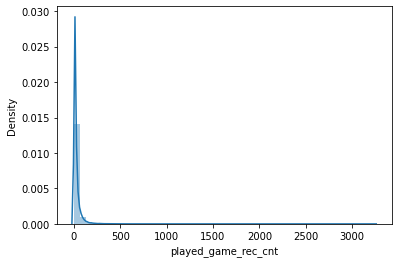

In [ ]:
sns.distplot(_user['played_game_rec_cnt'])